# Main analysis file

We load up one large dataframe consisting of all simulation sweeps and curves, produced by [src/get_all_data.py](../get_all_data.py).

In [1]:
import hydra
import torch

import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

## Load main dataframe

In [2]:
all_data_fp = "../../analysis_data/all_data.csv"

In [3]:
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_1451/2865108240.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,noise_cond_ent,ib_bound_function
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,2.748594,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,2.748594,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,2.748594,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,2.748594,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,2.748594,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160763,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo
160764,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo
160765,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo
160766,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo


## Set parameters for one theoretical bound

Using hydra compose overrides.

In [4]:
overrides = [
    # "game.universe=c1",

    "game.universe=100",
    "game.num_signals=100",

    # "game.universe=2ball_300",
    # "game.num_signals=300",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

#### Meaning distributions

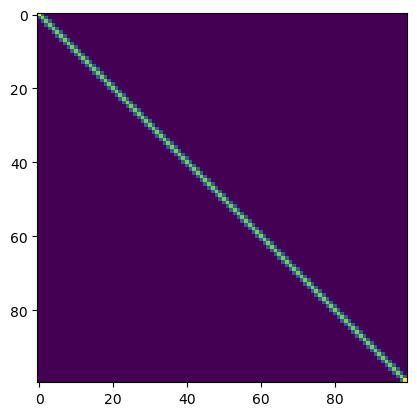

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

#### helper function for subsetting

In [6]:
def get_df_subsetted_by_bound(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & bound_func]

    return df_subsetted

### Subset dataframes for plotting

In [7]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,noise_cond_ent,ib_bound_function
98429,2.983033,2.951033,2.160638,20.342525,0.024574,-0.03067,0.742355,0.0,simulation,NaN,...,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN
98430,5.797586,4.268979,0.842691,1685.243800,NaN,NaN,NaN,1.0,trajectory,0.0,...,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN
98431,2.810301,2.755800,2.355870,39.393944,NaN,NaN,NaN,1.0,trajectory,1.0,...,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN
98432,2.821302,2.785093,2.326578,28.110016,NaN,NaN,NaN,1.0,trajectory,2.0,...,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN
98433,2.802565,2.773570,2.338101,26.525960,NaN,NaN,NaN,1.0,trajectory,3.0,...,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160763,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo
160764,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo
160765,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo
160766,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,NaN,embo


In [8]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

In [18]:
df_final_points

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,noise_cond_ent,ib_bound_function
98429,2.983033,2.951033,2.160638,20.342525,0.024574,-0.030670,0.742355,0.0,simulation,NaN,...,100,squared_dist,0.0,0,replicator_diffusion,0.1,2.0,42.0,3.162184,NaN
98631,2.959515,2.928449,2.183223,20.929840,0.025010,-0.025866,0.739026,0.0,simulation,NaN,...,100,squared_dist,0.0,0,replicator_diffusion,0.1,3.0,42.0,3.162184,NaN
98833,2.986829,2.954649,2.157021,20.248680,0.023705,-0.030433,0.742355,0.0,simulation,NaN,...,100,squared_dist,0.0,0,replicator_diffusion,0.1,-1.0,42.0,3.162184,NaN
99035,2.985717,2.953590,2.158080,20.276419,0.023964,-0.030502,0.742355,0.0,simulation,NaN,...,100,squared_dist,0.0,0,replicator_diffusion,0.1,1.0,42.0,3.162184,NaN
99237,2.986743,2.954572,2.157099,20.250664,0.023722,-0.030440,0.742355,0.0,simulation,NaN,...,100,squared_dist,0.0,0,replicator_diffusion,0.1,0.0,42.0,3.162184,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152993,5.288095,4.671210,0.440460,1.754280,0.018842,-0.018587,1.644483,0.0,simulation,NaN,...,100,squared_dist,-2.0,0,replicator_diffusion,10.0,-1.0,42.0,0.001427,NaN
153195,5.327361,4.628715,0.482957,2.216544,0.036638,-0.001966,1.744350,0.0,simulation,NaN,...,100,squared_dist,-2.0,0,replicator_diffusion,10.0,1.0,42.0,0.001427,NaN
153397,5.491189,4.745618,0.366053,1.612296,0.023568,-0.019914,1.887492,0.0,simulation,NaN,...,100,squared_dist,-2.0,0,replicator_diffusion,10.0,0.0,42.0,0.001427,NaN
153599,5.149392,4.569546,0.542125,2.164322,0.025590,0.009739,1.488025,0.0,simulation,NaN,...,100,squared_dist,-2.0,0,replicator_diffusion,10.0,-3.0,42.0,0.001427,NaN


### Plot

#### Trade-offs

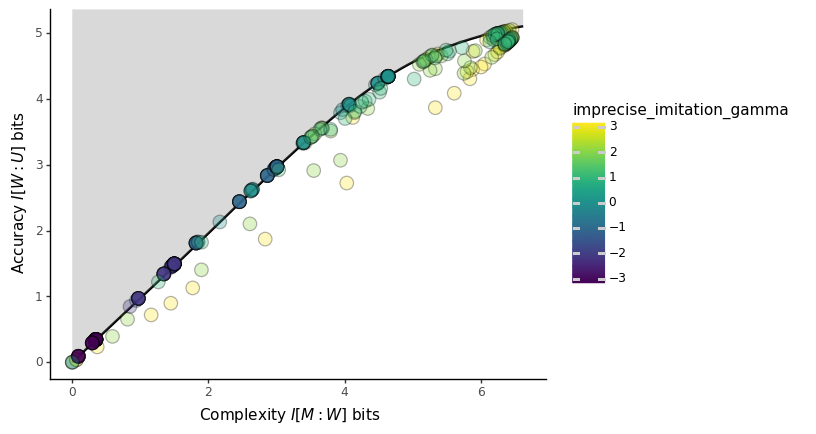

In [9]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="discriminative_need_gamma",
            fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

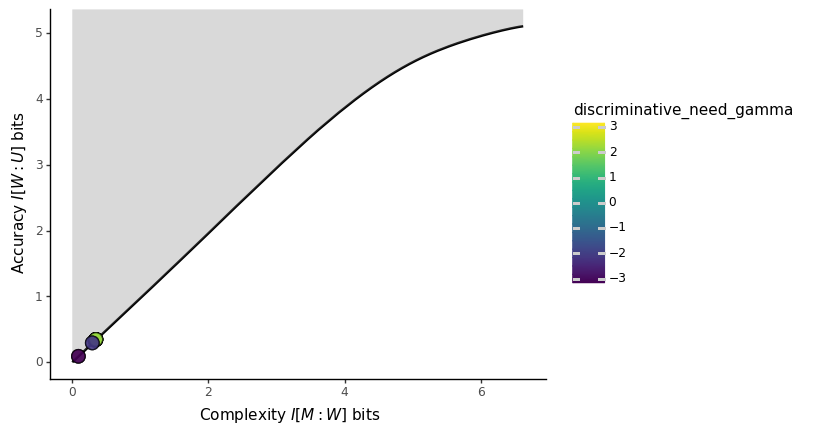

<ggplot: (685851138)>

In [10]:
# some scratch 
def plot_pressure_limits(
        pressure: str, 
        # pressure_min: float,
        # pressure_max: float,
        ) -> pn.ggplot:
    emergent_data = df_final_points[df_final_points["imprecise_imitation_gamma"] == -3]
    return (
        # Set data and the axes
        pn.ggplot(
            data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
        )  
        + pn.geom_line(size=1) # IB curve
        # + pn.geom_point(size=1)
        + pn.geom_ribbon(
        mapping=pn.aes(
            x="complexity",
            ymin="accuracy",
            ymax=torch.inf,
            ),
            fill="gray",
            alpha=0.3,
        )
        + pn.geom_point( # emergent langs
            data=emergent_data,
            mapping=pn.aes(
                fill = pressure,
                ),
            alpha=0.3,
            size=5,
        )        
        + pn.xlab("Complexity $I[M:W]$ bits")
        + pn.ylab("Accuracy $I[W:U]$ bits")
        + pn.theme_classic()
    )
plot_pressure_limits(
    pressure="discriminative_need_gamma",
    # pressure_min=0,
    # pressure_max=0,
)

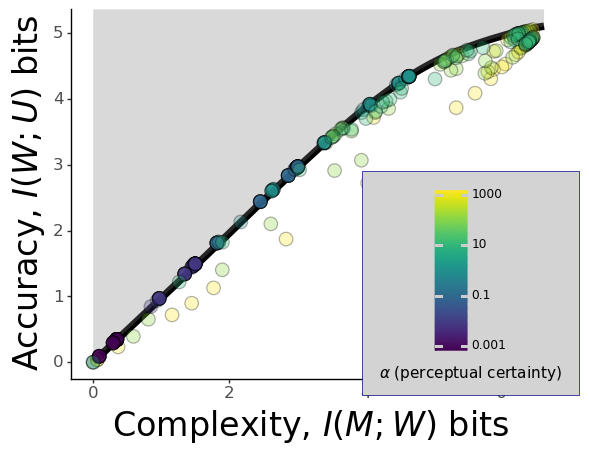

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: main_figure


In [11]:
# df_final_points["noise"] = df_final_points["noise_cond_ent"]
df_final_points["imprecise_imitation_gamma"] = 10 ** df_final_points["imprecise_imitation_gamma"]

plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="population_init_gamma",
            # fill="discriminative_need_gamma",
            # fill="noise",
            fill="imprecise_imitation_gamma",
            # shape="language",
            ),
        alpha=0.3,
        size=5,
    )
    # + pn.labs(fill="noise, $H(X|Y)$ bits")
    # + pn.labs(fill="discriminative need")
    # + pn.labs(fill="initialization energy")
    # + pn.labs(fill="perceptual certainty")
    + pn.labs(fill="$\\alpha$ (perceptual certainty)")
    + pn.scale_fill_continuous(
        trans = "log10",
    #     # breaks=[0., 0.5, 1.],
    #     breaks=[0., 1.,],
    #     # labels=["low", "mid", "high"],
    #     labels=["low", "high"],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    # force axes to origin. Note this blocks the perfectly simple point!
    # + pn.scale_x_continuous(expand = (0, 0)) 
    # + pn.scale_y_continuous(expand = (0, 0))

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            # title_hjust = 0.8,
            # title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("main_figure", width=6, height=6, dpi=300,)

In [12]:
df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["round"]
df_traj_points

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,noise_cond_ent,ib_bound_function,iteration
98430,5.797586,4.268979,0.842691,1685.243800,NaN,NaN,NaN,1.0,trajectory,0.0,...,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN,0.0
98431,2.810301,2.755800,2.355870,39.393944,NaN,NaN,NaN,1.0,trajectory,1.0,...,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN,1.0
98432,2.821302,2.785093,2.326578,28.110016,NaN,NaN,NaN,1.0,trajectory,2.0,...,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN,2.0
98433,2.802565,2.773570,2.338101,26.525960,NaN,NaN,NaN,1.0,trajectory,3.0,...,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN,3.0
98434,2.795239,2.768253,2.343418,26.193102,NaN,NaN,NaN,1.0,trajectory,4.0,...,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,3.162184,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153997,5.155763,4.576180,0.535491,2.147382,NaN,NaN,NaN,1.0,trajectory,195.0,...,squared_dist,-2.0,0,replicator_diffusion,1.0,-2.0,42.0,0.001427,NaN,195.0
153998,5.158834,4.577537,0.534134,2.143226,NaN,NaN,NaN,1.0,trajectory,196.0,...,squared_dist,-2.0,0,replicator_diffusion,1.0,-2.0,42.0,0.001427,NaN,196.0
153999,5.161887,4.578883,0.532787,2.139115,NaN,NaN,NaN,1.0,trajectory,197.0,...,squared_dist,-2.0,0,replicator_diffusion,1.0,-2.0,42.0,0.001427,NaN,197.0
154000,5.164921,4.580216,0.531455,2.135051,NaN,NaN,NaN,1.0,trajectory,198.0,...,squared_dist,-2.0,0,replicator_diffusion,1.0,-2.0,42.0,0.001427,NaN,198.0


In [13]:
# df_traj_points[df_traj_points["imprecise_imitation_gamma"] == 0.]

new_df = df_traj_points.loc[(df_traj_points['imprecise_imitation_gamma'] == 3) & (df_traj_points['population_init_gamma'] == -2) & (df_traj_points["discriminative_need_gamma"] == -2)]

# new_df = df_traj_points.loc[(df_traj_points['imprecise_imitation_gamma'] == 3) & (df_traj_points["discriminative_need_gamma"] == -2)]

# new_df = df_traj_points.loc[(df_traj_points['population_init_gamma'] == -2) & (df_traj_points["discriminative_need_gamma"] == -2)]

new_df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,noise_cond_ent,ib_bound_function,iteration
113674,0.000071,0.000027,5.111644,1666.307500,NaN,NaN,NaN,1.0,trajectory,0.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,0.0
113675,0.000072,0.000031,5.111640,1591.618900,NaN,NaN,NaN,1.0,trajectory,1.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,1.0
113676,0.000093,0.000050,5.111621,1535.745800,NaN,NaN,NaN,1.0,trajectory,2.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,2.0
113677,0.000195,0.000153,5.111518,1493.426900,NaN,NaN,NaN,1.0,trajectory,3.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,3.0
113678,0.000753,0.000708,5.110963,1460.326400,NaN,NaN,NaN,1.0,trajectory,4.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113869,5.168785,4.580712,0.530958,2.061376,NaN,NaN,NaN,1.0,trajectory,195.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,195.0
113870,5.171596,4.581925,0.529745,2.057692,NaN,NaN,NaN,1.0,trajectory,196.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,196.0
113871,5.174391,4.583128,0.528543,2.054044,NaN,NaN,NaN,1.0,trajectory,197.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,197.0
113872,5.177168,4.584321,0.527350,2.050429,NaN,NaN,NaN,1.0,trajectory,198.0,...,squared_dist,-2.0,0,replicator_diffusion,3.0,-2.0,42.0,0.0,NaN,198.0


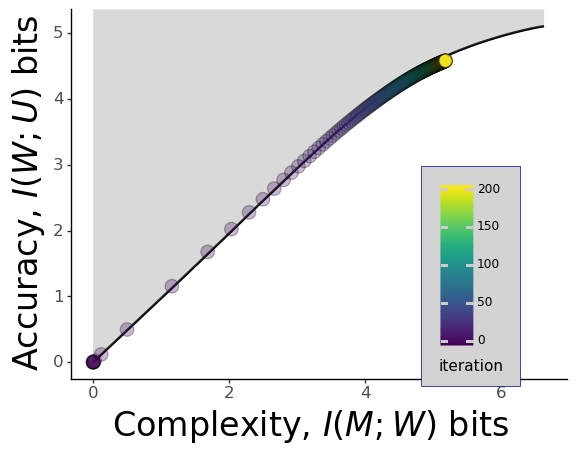

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 6 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: traj_figure


In [14]:
threshold = -1
df_sample_traj = df_traj_points[df_traj_points["imprecise_imitation_gamma"] == threshold]
df_sample_points = df_final_points[df_final_points["imprecise_imitation_gamma"] == threshold]
# df_sample_traj = df_sample_traj[df_sample_traj["discriminative_need_gamma"] == 0]

# just want like three representative trajectories.


plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    # + pn.geom_point(size=1)
    + pn.geom_line(size=1) # IB curve    
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # trajectories
    # + pn.geom_line(
        data=new_df,
        mapping=pn.aes(
            fill="iteration",
            # color="imprecise_imitation_gamma"
            # color="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )
    # + pn.geom_point( # emergent langs
    #     data=df_sample_points,
    #     mapping=pn.aes(
    #         color="population_init_gamma",
    #         ),
    #     # alpha=0.05,
    #     shape="X",
    #     size=3,
    # )    
    + pn.labs(fill="iteration")
    + pn.scale_fill_continuous(
        breaks=[0, 50, 100, 150, 200],
        limits=[0, 200],
    )
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    # force axes to origin. Note this blocks the perfectly simple point!
    # + pn.scale_x_continuous(expand = (0, 0)) 
    # + pn.scale_y_continuous(expand = (0, 0))

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.325),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        # fill = pn.guide_legend(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            # hjust = 0.5 centers the title horizontally
            title_hjust = 0.8,
            title_vjust = 2.,
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            # nrow=3,
            ),
    ) 
)
print(plot)
plot.save("traj_figure", width=6, height=6, dpi=300,)

### 3D plot of parameterspace

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_1451/3274004497.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


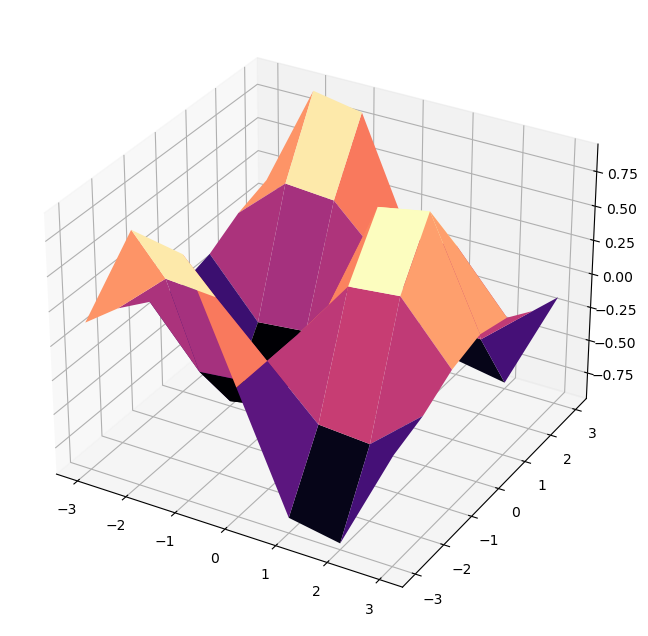

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

f = lambda x, y: np.sin(x) * np.cos(y)
# x = np.linspace(-3, 3, 100)
# y = np.linspace(-3, 3, 100)
x = np.arange(-3, 4)
y = np.arange(-3, 4)
X, Y = np.meshgrid(x, y)
F = f(X, Y)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, F, cmap='magma')
plt.show()

In [16]:
print(X.shape)
print(Y.shape)
print(F.shape)

(7, 7)
(7, 7)
(7, 7)


In [17]:
def lookup_efficiency(discr_need: int, imprecision: int) -> float:
    df_discr = df_final_points[df_final_points["discriminative_need_gamma"] == discr_need]
    df_imprecision = df_discr[df_discr["imprecise_imitation_gamma"] == imprecision]
    # need to fix population init
    df_result = df_imprecision[df_imprecision["population_init_gamma"] == 0.]
    eps = float(df_result["eps"].tolist()[0]) # return singleton
    return eps

x = np.arange(-3, 4) # discr_need
y = np.arange(-3, 4) # imprecise imitation

X, Y = np.meshgrid(x, y)

# we need to create the equivalent of matrix elementwise multiplication / conjunction.
# if before we had sin(x) * cos(y),
# this was really
# sin(x_ij) * cos(y_ij) for i in ... for j in ...
# 
# then before our df[...] == x & df[...] == y
# should be df[...] == x_ij & df[...] == y_ij for i in ... for j in ...

# square matrix, so we can just use length
n = len(X)
F = np.array([[lookup_efficiency(
    discr_need=X[i,j], 
    imprecision=Y[i,j],
    ) for i in range(n)] for j in range(n)])


def plotter(E, A):
    fig = plt.figure(figsize=[12,8])
    ax = fig.gca(projection='3d')
    ax.plot_surface(
        X=X, Y=Y, Z=F, 
        cmap="viridis",
    )
    ax.view_init(elev=E, azim=A)
    ax.set_xlabel('Discriminative need')
    ax.set_ylabel('Imprecise imitation')
    ax.set_zlabel('Efficiency loss')
    plt.show()

plotter(20, 70)

IndexError: list index out of range

In [ ]:
# inspect X and Y
X, Y

(array([[-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3],
        [-3, -2, -1,  0,  1,  2,  3]]),
 array([[-3, -3, -3, -3, -3, -3, -3],
        [-2, -2, -2, -2, -2, -2, -2],
        [-1, -1, -1, -1, -1, -1, -1],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3]]))

### Parallel coordinates?

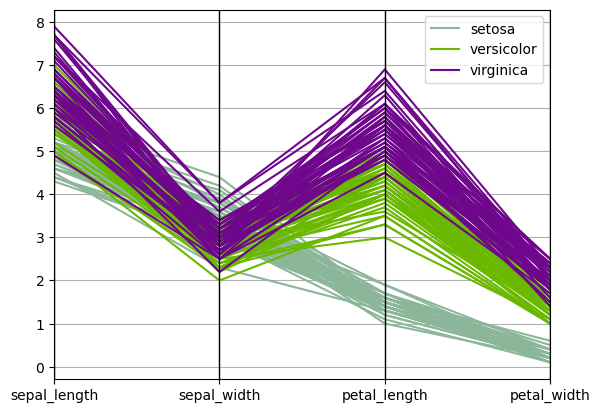

In [ ]:
from pandas.plotting import parallel_coordinates

iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

parallel_coordinates(iris, 'species')
plt.show()


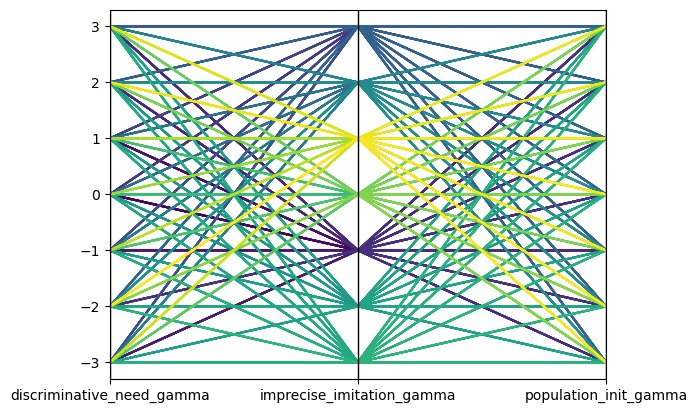

In [ ]:
parallel_coordinates(df_final_points[["discriminative_need_gamma", "imprecise_imitation_gamma", "population_init_gamma", "eps"]], 'eps', colormap='viridis')
plt.gca().legend_.remove()
plt.show()


In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [19]:
import plotly.express as px

# df_pcs = df_final_points[["discriminative_need_gamma", "imprecise_imitation_gamma", "population_init_gamma", "eps"]]

# df_final_points["efficiency"] = 1 - df_final_points["eps"] # i don't think F is bounded by one, just need something.

# parallel_data = df_final_points[df_final_points["eps"] >= -np.inf]
parallel_data = df_final_points.copy()
parallel_data["eps"] = parallel_data["eps"] - min(df_final_points["eps"])

fig = px.parallel_coordinates(
    data_frame=parallel_data, 
    dimensions=[
        "population_init_gamma",
        "discriminative_need_gamma",
        "imprecise_imitation_gamma",
        ],
    color="eps",
    # color="efficiency",
    labels={
        "population_init_gamma": "Initialization Energy",
        "discriminative_need_gamma": "Discriminative Need",
        "imprecise_imitation_gamma": "Perceptual Certainty",
        "eps": "Efficiency Loss",
        # "efficiency": "Efficiency",
        },
    # color_continuous_scale='viridis',
    color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=0.6,
)
fig.show()
fig.write_image("parcoord.pdf", format="pdf")

In [20]:
# add dummy columns to see how crowded things get
df_example = df_final_points.copy()

df_example["prior_entropy"] = df_example["discriminative_need_gamma"]
df_example["universe_size"] = df_example["prior_entropy"]

fig = px.parallel_coordinates(
    data_frame=df_example[df_example["eps"] >= 0.], 
    dimensions=[
        "universe_size",
        "prior_entropy",
        "population_init_gamma",        
        "discriminative_need_gamma",
        "imprecise_imitation_gamma",
        ],
    color="eps",
    # color="efficiency",
    labels={
        "population_init_gamma": "Initialization Temperature",        
        "discriminative_need_gamma": "Discriminative Need",
        "imprecise_imitation_gamma": "Perceptual Certainty",
        "prior_entropy": "Communicative Need Entropy",
        "universe_size": "Universe Size",
        "eps": "Efficiency Loss",
        # "efficiency": "Efficiency",
        },
    color_continuous_scale='viridis',
    # color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=0.2,
)
fig.show()

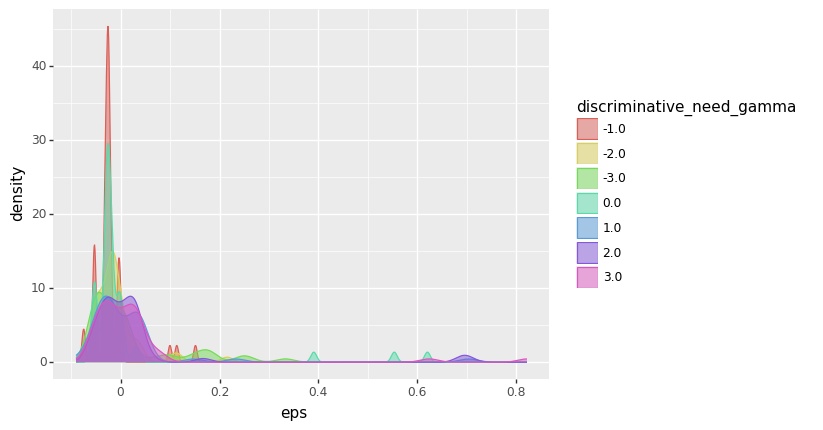

<ggplot: (693653441)>

In [37]:
# Easier: histogram of efficiency.
# efficiency loss = eps
# df = df_final_points[df_final_points["eps"] > 0.]
df = df_final_points.copy()
# df = parallel_data.copy()

pressure = "discriminative_need_gamma"
df[pressure] = [ str(item) for item in df[pressure].tolist()]

hist = (
    pn.ggplot(data=df, mapping=pn.aes(x="eps", fill=pressure, color=pressure))
    + pn.geom_density(alpha=0.5)
)
print(hist)
hist.save("epsilon_histogram", width=6, height=6, dpi=300,)

In [45]:
eps = [ep for ep in df_final_points["eps"].tolist() if not np.isnan(ep)]
print(min(eps))
print(np.median(eps))

-0.0900829508900642
-0.0209826659411191


### Correlations

In [22]:
from scipy.stats import linregress, pearsonr

complexity

LinregressResult(slope=0.0023342337794980913, intercept=3.0283154937103394, rvalue=0.36683538731134574, pvalue=2.2970969626082696e-12, stderr=0.0003205622372655222, intercept_stderr=0.12177152449990053)


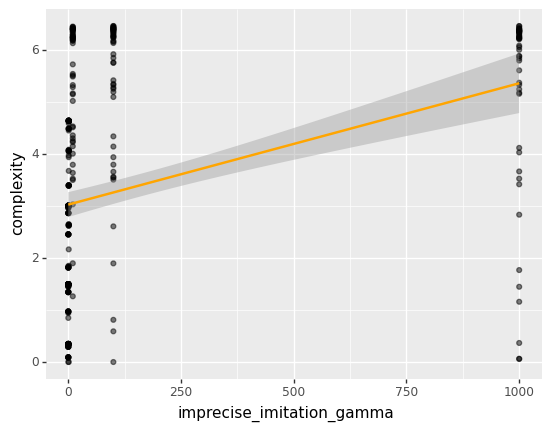

<ggplot: (688537420)>

In [23]:
print(linregress(
    df_final_points["imprecise_imitation_gamma"],
    df_final_points["complexity"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="imprecise_imitation_gamma", y="complexity"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

In [24]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = np.array([ df_final_points["discriminative_need_gamma"].tolist(), 
        df_final_points["imprecise_imitation_gamma"].tolist(), 
        df_final_points["population_init_gamma"].tolist(), 
        ]).T
y = np.array(df_final_points["complexity"].tolist())
reg = reg.fit(X, y)
print(reg.coef_) # indeed the same!
print(reg.score(X, y)) # strictly less info than individual regressions.

[ 0.07240267  0.00233423 -0.21488258]
0.17721516249630276


LinregressResult(slope=0.07240266762973337, intercept=3.39882875499204, rvalue=0.06593965169038428, pvalue=0.2231907128525269, stderr=0.0593313877539817, intercept_stderr=0.1186627755079634)


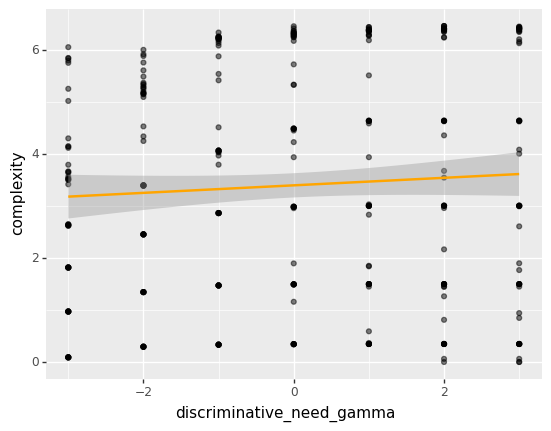

<ggplot: (693270811)>

In [25]:
print(linregress(
    df_final_points["discriminative_need_gamma"],
    df_final_points["complexity"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

LinregressResult(slope=-0.2148825763016907, intercept=3.39882875499204, rvalue=-0.19570110742503988, pvalue=0.00026580980980037524, stderr=0.05831103910545376, intercept_stderr=0.11662207821090752)


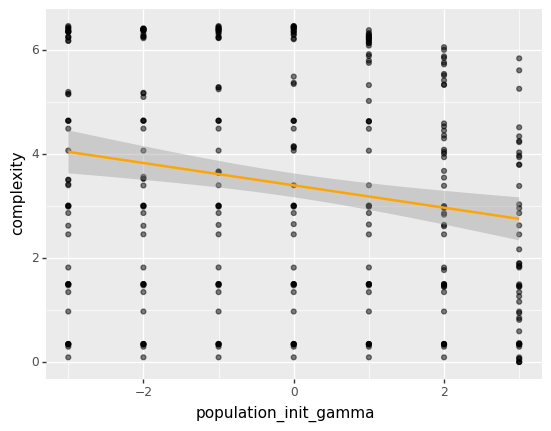

<ggplot: (693271234)>

In [26]:
print(linregress(
    df_final_points["population_init_gamma"],
    df_final_points["complexity"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="population_init_gamma", y="complexity"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

LinregressResult(slope=0.00010184341939473596, intercept=-0.005713433285225361, rvalue=0.3136109974170066, pvalue=2.895709486852953e-09, stderr=1.6698714717447906e-05, intercept_stderr=0.006343317184451348)


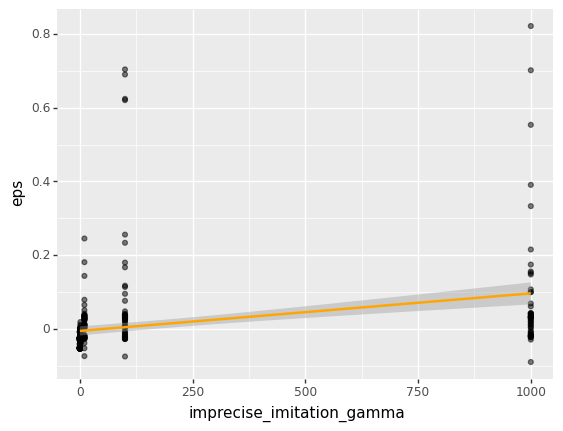

<ggplot: (688537438)>

In [27]:
print(linregress(
    df_final_points["imprecise_imitation_gamma"],
    df_final_points["eps"],
))
(
    pn.ggplot(df_final_points, pn.aes(x="imprecise_imitation_gamma", y="eps"))
    + pn.geom_point(alpha=0.5)
    + pn.geom_smooth(color="orange", method="lm")
)

efficiency

In [28]:
# df_positive_eps = df_final_points[df_final_points["eps"] > 0.]
# temporary solution: find the max negative eps, and add that to everyone.

min_eps = min(df_final_points["eps"])

df_positive_eps = df_final_points.copy()
df_positive_eps["eps"] = df_positive_eps["eps"] - min_eps # minus neg

LinregressResult(slope=0.00010184341939473596, intercept=0.08436951760483885, rvalue=0.3136109974170066, pvalue=2.895709486852953e-09, stderr=1.6698714717447906e-05, intercept_stderr=0.006343317184451348)


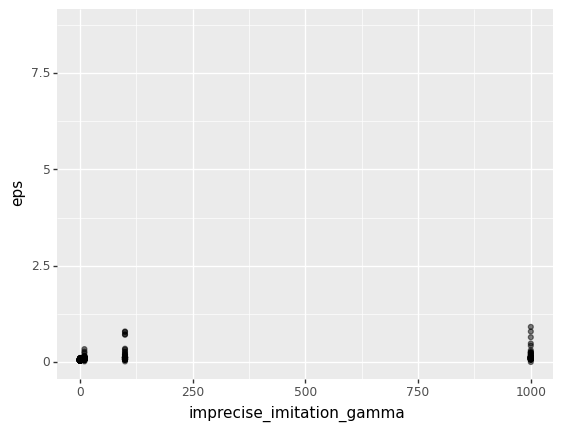

<ggplot: (693367968)>

In [29]:
print(linregress(
    df_positive_eps["imprecise_imitation_gamma"],
    df_positive_eps["eps"]
))
(
    pn.ggplot(df_positive_eps, pn.aes(x="imprecise_imitation_gamma", y="eps"))
    + pn.geom_point(alpha=0.5)
    # + pn.geom_smooth(color="orange")
    + pn.geom_col()
)

Cleaned up regressions

In [30]:
import patchworklib as pw

No module named 'seaborn'


<Figure size 100x100 with 0 Axes>

In [31]:
noise_comp_reg_p = (
    pn.ggplot(df_final_points, pn.aes(x="imprecise_imitation_gamma", y="complexity"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Perceptual Certainty, $\\alpha$")
    + pn.ylab("Complexity, $I(M;W)$ bits")
    # + pn.ylab("Efficiency loss, $\epsilon$")
)

discr_comp_reg_p = (
    pn.ggplot(df_final_points, pn.aes(x="discriminative_need_gamma", y="complexity"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Discriminative Need, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)

init_comp_reg_p = (
    pn.ggplot(df_final_points, pn.aes(x="population_init_gamma", y="complexity"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Initialization Energy, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)



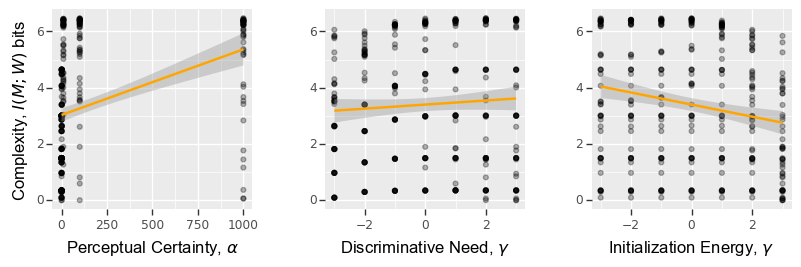

In [32]:
p1 = pw.load_ggplot(noise_comp_reg_p, figsize=(2,2))
p2 = pw.load_ggplot(discr_comp_reg_p, figsize=(2,2))
p3 = pw.load_ggplot(init_comp_reg_p, figsize=(2,2))

g = (p1 | p2 | p3)

g.savefig("comp_reg_multiplot.png")

In [33]:
noise_eps_reg_p = (
    pn.ggplot(df_positive_eps, pn.aes(x="imprecise_imitation_gamma", y="eps"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Perceptual Certainty, $\\alpha$")
    + pn.ylab("Efficiency loss, $\epsilon$")
)

discr_eps_reg_p = (
    pn.ggplot(df_positive_eps, pn.aes(x="discriminative_need_gamma", y="eps"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Discriminative Need, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)

init_eps_reg_p = (
    pn.ggplot(df_positive_eps, pn.aes(x="population_init_gamma", y="eps"))
    + pn.geom_point(alpha=0.3)
    + pn.geom_smooth(color="orange", method="lm")
    + pn.xlab("Initialization Energy, $\\gamma$")
    + pn.theme(axis_title_y=pn.element_blank())
)

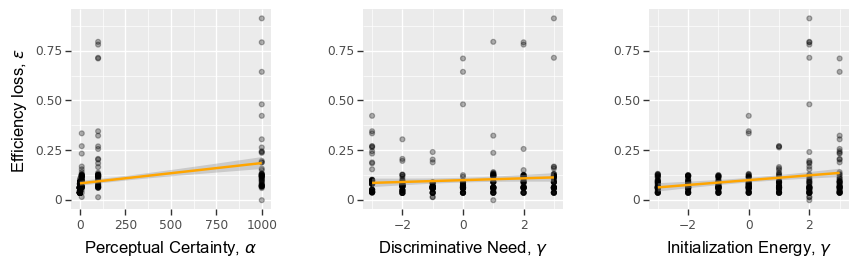

In [34]:
p1 = pw.load_ggplot(noise_eps_reg_p, figsize=(2,2))
p2 = pw.load_ggplot(discr_eps_reg_p, figsize=(2,2))
p3 = pw.load_ggplot(init_eps_reg_p, figsize=(2,2))

g = (p1 | p2 | p3)

g.savefig("eps_reg_multiplot.png")

In [35]:
print(linregress(
    df_positive_eps["imprecise_imitation_gamma"],
    df_positive_eps["eps"],
))
print(linregress(
    df_positive_eps["discriminative_need_gamma"],
    df_positive_eps["eps"],
))
print(linregress(
    df_positive_eps["population_init_gamma"],
    df_positive_eps["eps"],
))

LinregressResult(slope=0.00010184341939473596, intercept=0.08436951760483885, rvalue=0.3136109974170066, pvalue=2.895709486852953e-09, stderr=1.6698714717447906e-05, intercept_stderr=0.006343317184451348)
LinregressResult(slope=0.00456361572583001, intercept=0.1005351381144252, rvalue=0.0814390288414538, pvalue=0.13225535059200946, stderr=0.0030245049966660456, intercept_stderr=0.006049009993332091)
LinregressResult(slope=0.012102931448425964, intercept=0.1005351381144252, rvalue=0.21598027584043233, pvalue=5.504336891232719e-05, stderr=0.0029629617972969703, intercept_stderr=0.0059259235945939405)


### What are the mean, median efficiency of all sims?

In [36]:
print(df_positive_eps["eps"].mean())
print(df_positive_eps["eps"].median())
print(df_positive_eps["eps"].std())
print(df_positive_eps["eps"].min())
print(df_positive_eps["eps"].max())

0.1005351381144252
0.0691002849489451
0.11223814609827604
0.0
0.9117019847035408
